# Feature Extraction

As the data we chose consisted of raw audio waveforms of different lengths, we needed to extract length-independant features capable of capturing the essence of the various classes considered. The team members worked in parallel to design and extract a large number of features, with the goal of eventually pruning them down by testing their efficacity when used to train classifier models. In this notebook, we will separately describe the different feature sets we worked on.

All the resulting features are combined in the file "extracted_features.csv"

##### Running this notebook

As the feature extraction is computationally expensive, we do not recommend running the final part of the notebook (i.e. the part that loops through all data files). In fact, part of the feature extraction code shown here is a simplified demonstrational version of parallelized code (included in the file "cleaning.py") that was run on a 20-core workstation. Additionally, the code shown here does not do the final step of combining all separately-extracted features into a single CSV file.

## Preparations

We load in required packages, as well as the metadata file provided along with the dataset.

In [1]:
# Standard data handling and plotting packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy

# Librosa is a widely use audio analysis package
# NOTE: librosa dependencies apparently require specific versions of numpy, try numpy==1.21.4 if encountering issues
import librosa
import librosa.display

# We can listen to the audio files by importing this package
import IPython.display

In [2]:
# Function to load wav file with librosa, given a row from metadata table
def load_data(meta_row,sr=None):
    filename = meta_row['slice_file_name']
    filepath = f'large_data/UrbanSound8K/audio/fold{meta_row["fold"]}/'
    return librosa.load(filepath+filename,sr=sr)

In [3]:
# Data should be placed in the "large_data/" directory, which is not staged in the git repo

# The dataset includes a metadata CSV that lists the audio file names, pre-chosen fold, class label, etc.
metadata = pd.read_csv('large_data/UrbanSound8K/metadata/UrbanSound8K.csv')

## Feature Set 1: Human-understandable & Musically-informed

The various audiofiles do not exhibit a uniform length or sampling rate. As such we aim to do some pre-classification analysis to generate a uniform observable vector.

For this reason we are going to take inspiration from the idea of a music "equalizer" scale. We will break down the fourier transform of each audio section into a number of human audible frequencies, as well as the sub-audible and supra-audible sections.

<img src="FrequencySpectrumDivision-1.jpeg" width="600" height="300">

(Image source: https://blog.landr.com/sound-frequency-eq/ )

We will also extract the so-called "crest factor", a feature that measures the "suddenness" of a sound. Crest factor, sometime also referred to as peak-to-average power ratio, is defined as
\begin{equation}
Cr = \frac{max(amplitude)}{rms(amplitude)}\,
\end{equation}
where "rms" stands for Root Mean Square.

However, before extracting these features, we will first attempt to decrease the background noise present in the audio samples. We do so using the absolute value of the Hilbert transform, which extracts the instantaneous amplitude of a signal, effectively giving us an "envelope" for our waveform. Smoothing this transform and dividing by the root mean square power should then amplify the parts of the signal that are large in amplitude, while minimizing the areas that are simply a constant amplitude "hum". Low crest factor systems will be largely unaffected as the amplitude will be similar to the root mean square of the signal for such signals. Finally we ensure that the maximum amplitude of the signal is scaled to be equal to the input signal.

We demonstrate the cleaning and extraction procedure on one audio sample:

In [4]:
# Sample is of gun_shot class
row = metadata.loc[106]
test_y, sr = load_data(row)

print(f'Class: {row["class"]}')
print(f'Duration: {round(row["end"]-row["start"],3)}s')
print(f'Salience: {"foreground" if row["salience"]==1 else "background"}')

Class: gun_shot
Duration: 2.612s
Salience: foreground


In [5]:
# As we'll be working in Fourier space, we prepare the list of k-vectors (wavenumbers)

t = round(row["end"]-row["start"],3) # Length of audio sample in seconds
dt = t/len(test_y) # Time separation between signal values in the waveform

k = np.fft.fftfreq(len(test_y), d=dt) # List of k-vectors

We prepare the unfiltered and filtered Hilbert transforms of the original waveform:

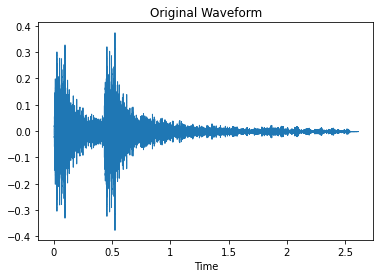

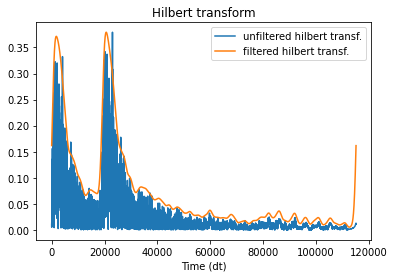

In [6]:
# Original waveform plot
librosa.display.waveshow(test_y,sr=sr)
plt.title('Original Waveform')
plt.show()

# Unfiltered hilbert transform
hil = np.abs(scipy.signal.hilbert(test_y))

# Filter the hilbert transform
hilk = np.fft.fft(hil)
hilk *= np.exp(-k*k / (2*10**2))
hil2 = np.fft.ifft(hilk)
hil2 = np.abs(hil2)
hil2 *= hil.max() / hil2.max()

# Plot unfiltered and filtered hilbert transform
plt.plot(hil, label='unfiltered hilbert transf.')
plt.plot(np.abs(hil2), label='filtered hilbert transf.')
plt.xlabel('Time (dt)')
plt.legend()
plt.title('Hilbert transform')
plt.show()

Now, we use the Hilbert transforms to scale the waveform. Note how both unfiltered and filtered Hilbert scaling lead to far less background echo than the original audio sample. Further, note how the filtered transform avoids the audio distortion cased by the unfiltered transform.

In [7]:
# Original audio signal
display(IPython.display.Audio(test_y / (test_y.max()*10), rate=sr, normalize=False))

In [8]:
# Unfiltered hilbert scaling
testwav = test_y * hil/np.sqrt((test_y*test_y).mean())
testwav *= test_y.max() / testwav.max()

display(IPython.display.Audio(testwav / (testwav.max()*10), rate=sr, normalize=False))

In [9]:
# filtered hilbert scaling
testwav2 = test_y * hil2/np.sqrt((test_y*test_y).mean())
testwav2 *= test_y.max() / testwav2.max()

display(IPython.display.Audio(testwav2 / (testwav2.max()*10), rate=sr, normalize=False))

We now generate the equilizer values by manually summing over the relevent portions of fourier space. Here we do this with each of the 3 signals to see how our cleaning step is affecting the results:

In [10]:

# As described previously, these frequency cutoffs are chosen to span a range from sub-audible and supra-audible
eq_cutoffs = [20.0, 40.0, 80.0, 160.0, 300.0, 600.0, 1200.0, 2400.0, 5000.0, 10000.0, 20000.0, np.inf]

equilizer = np.zeros(12)
equilizer2 = np.zeros(12)
equilizer3 = np.zeros(12)

# Calculate the absolute value of the Fourier transform for each signal (original, unfiltered hilbert scale, filtered hilbert scale)
yk = np.fft.fft(test_y)
mag_yk = np.abs(yk)
mag_yk = mag_yk[:len(mag_yk)//2]

ykclean = np.fft.fft(testwav)
mag_ykclean = np.abs(ykclean)
mag_ykclean = mag_ykclean[:len(mag_ykclean)//2]

ykclean2 = np.fft.fft(testwav2)
mag_ykclean2 = np.abs(ykclean2)
mag_ykclean2 = mag_ykclean2[:len(mag_ykclean2)//2]

# Loops over each frequency band and sum the included frequencies
index = 0
for i in range(0,12):
    num = 0
    while ((index < len(mag_yk)) & (k[index] < eq_cutoffs[i])):
        equilizer[i] += mag_yk[index]
        equilizer2[i] += mag_ykclean[index]
        equilizer3[i] += mag_ykclean2[index]
        index += 1
        num += 1
    equilizer[i] /= num
    equilizer2[i] /= num
    equilizer3[i] /= num
    
equilizer /= equilizer.max()
equilizer2 /= equilizer2.max()
equilizer3 /= equilizer3.max()

Sanity check with some plots. We notice that the unfiltered version of our clean up step displays distortion in the numerical data as well as testing by ear.

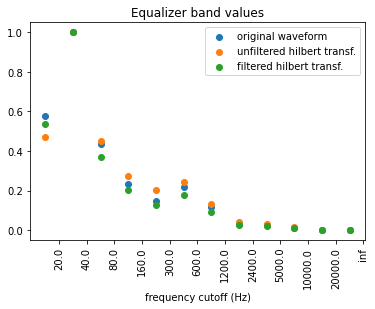

In [38]:
plt.scatter(range(0,12),equilizer, label='original waveform')
plt.scatter(range(0,12),equilizer2, label='unfiltered hilbert transf.')
plt.scatter(range(0,12),equilizer3, label='filtered hilbert transf.')
plt.title('Equalizer band values')
plt.xticks(ticks=np.array(range(0,12))+0.5, labels=eq_cutoffs, rotation=90)
plt.legend()
plt.xlabel('frequency cutoff (Hz)')
plt.show()

And as stated before, we calculate the Crestfactor (from the filtered Hilbert scaling of the signal), a single scalar value for the audio file that encapsulates the "suddenness" of the noise:

In [12]:
crestfactor = testwav2.max() / np.sqrt((testwav2*testwav2).mean())
print(crestfactor)

11.781360561168665


### Quantifying musicality

As we tested these extracted features, including in the classifier models described in the next notebook, we noticed some odd behavior:

1. The classifiers stuggle to differentiate between street music and other types of data.
2. Gun shots and children playing are often confused with each other, possibly due to the crest factor picking up on the "suddeness" of children's voices

We expect that children playing and street music should be a much more "musical" type of sound than gun shots. For these two reasons we are going to try and extract some music based features.

Librosa has a function to decompose the harmonic and percussive components of a spectrogram. This is done by checking for peaks in the fourier domain (harmonic) and time domain (percussive).

In [13]:
# Calculate the Short Time Fourier Transform of the filtered Hilbert scaled waveform
D = librosa.stft(testwav2 / testwav2.max())

# Decompose into harmonic and percussive components
y_harmonic, y_percussive = librosa.decompose.hpss(D,margin=16.0)

The decomposition loses a certain amount of power based on the 'margin' command which essentially sets how harsh the decomposition should be. For this reason we are going to rescale the power such that the sum of the two components still holds the same level of total power.

In [14]:
# Inverse short-time Fourier transform of the two components
y_p = librosa.istft(y_percussive, length=len(testwav2))
y_h = librosa.istft(y_harmonic, length=len(testwav2))

Ptot = (testwav2**2).mean() # Total power
ynorm = testwav2 / np.sqrt(Ptot)
Pnorm = (ynorm**2).mean()

P_p = (y_p**2).mean() # percussive power
P_h = (y_h**2).mean() # harmonic power
Anorm = np.sqrt(Pnorm/(P_h+P_p))

# Obtain the two components and their powers subject to the rescaling that conserves total power
y_p *= Anorm
y_h *= Anorm
P_p = (y_p**2).mean()
P_h = (y_h**2).mean()

From the harmonic component we are going to generate a measure of the harmonics within the sound wave. A great deal of music is made up of chords from major thirds, minor thirds, major fifths, and a triplet consisting of a base frequency with its major third and major fifth.

The following approach and all calculations follow the book "Müller, Meinard. Fundamentals of music processing: Audio, analysis, algorithms, applications. Vol. 5. Cham: Springer, 2015."

The first thing we are going to do is extract the mean power in the various frequencies corresponding to different MIDI keys. MIDI keys are essentially just integer numbers corresponding to the frequencies produced keys on a piano tuned using equal temperament. The equation for the central frequency of each MIDI index is

\begin{equation}
    F_\mathrm{pitch}(p) = 2^{(p-69)/12} 440 \;\mathrm{Hz}.
\end{equation}

The bandwidth of the MIDI frequency then ranges from $p-0.5$ to $p+0.5$.

A major third is then a pair consisting of a base frequency (MIDI $n$) and the key whose central frequency is closest to $3 f_n /2$. In a MIDI keyboard this then is the pair (MIDI $n$)+(MIDI $n+4$). Similarly minor thirds are (MIDI $n$)+(MIDI $n+3$), and major fifths are (MIDI $n$)+(MIDI $n+7$).

In [15]:
st_k = np.fft.fftfreq(np.size(y_harmonic,0), d=dt)
fbins = []
keypitch = []
midi = []
maxlen=np.size(y_harmonic,0)
p = -69
kmin = 440*2**((p - 0.5)/12)
kmax = 440*2**((p+0.5)/12)
while kmax <= 20000:
    kmin = 440*2**((p - 0.5)/12)
    kmax = 440*2**((p+0.5)/12)
    if (len(np.abs(y_harmonic[(st_k[:maxlen] <= kmax) & (st_k[:maxlen] > kmin),0])) != 0) :
        sumbin = np.abs(y_harmonic[(st_k[:maxlen] <= kmax) & (st_k[:maxlen] > kmin),0]).sum() / len(np.abs(y_harmonic[(st_k[:maxlen] <= kmax) & (st_k[:maxlen] > kmin),0]))
    else:
        sumbin = 0
    fbins.append(sumbin)
    keypitch.append(440*2**(p/12))
    midi.append(p+69)
    p += 1

peaks = librosa.util.localmax(np.asarray(fbins))

In [16]:
maj3 = []
min3 = []
maj5 = []
majchord = []
fbins = np.asarray(fbins)
favg = fbins[fbins > 0].max()
for i in range(len(fbins)-4):
    maj3.append(peaks[i]*peaks[i+4]*(fbins[i] + fbins[i+4])/favg)
for i in range(len(fbins)-3):
    min3.append(peaks[i]*peaks[i+3]*(fbins[i] + fbins[i+3])/favg)
for i in range(len(fbins)-7):
    maj5.append(peaks[i]*peaks[i+7]*(fbins[i] + fbins[i+7])/favg)
    majchord.append(peaks[i]*peaks[i+4]*peaks[i+7]*(fbins[i] + fbins[i+4] + fbins[i+7])/favg)


maj3 = np.asarray(maj3)
min3 = np.asarray(min3)
maj5 = np.asarray(maj5)
majchord = np.asarray(majchord)
harmonicality  = len(maj3[np.log10(maj3+1e-12)>=-0.5]) + len(min3[np.log10(min3+1e-12)>=-0.5])+len(maj5[np.log10(maj5+1e-12)>=-0.5])+len(majchord[np.log10(majchord+1e-12)>=-0.5])
print("There are ",len(maj3[np.log10(maj3+1e-12)>=-0.5])," major third(s), ",
      len(min3[np.log10(min3+1e-12)>=-0.5])," minor third(s), ",
      len(maj5[np.log10(maj5+1e-12)>=-0.5])," major third(s), and ",
      len(majchord[np.log10(majchord+1e-12)>=-0.5])," major chord(s).")


There are  0  major third(s),  0  minor third(s),  1  major third(s), and  0  major chord(s).


While the code seems to pick up a major third in the sample we know to be a gunshot, we hope that actually 'musical' samples would pick up more harmonic signals as well as more power in the harmonic component.

We also want to recognize the percussive hits. This is easy enough to do using the librosa onset_strength function. We then use peak detection to generate the total number of percussive crashes in the soundwave.

In [19]:
y_out = librosa.istft(y_percussive, length=len(test_y))
times = librosa.times_like(y_percussive)
onset_env = librosa.onset.onset_strength(y=y_out, sr=sr,
                                         max_size=5,
                                          aggregate=np.median)

perc_peaks = librosa.util.peak_pick(onset_env, pre_max=3, post_max=3, pre_avg=3, post_avg=5, delta=0.5, wait=0)
print("Percussive peaks are at ", perc_peaks, "for a total length of ", len(perc_peaks))

Percussive peaks are at  [ 3 38] for a total length of  2


The code picks up the position and number of percussive peaks in the waveform. We expect that certain music, as well as possibly jackhammers or other such percussive sounds, would be easily recognizable through this feature.

### Generating feature set 1

Below is the function that can generate a CSV of the features described in this section, for all audio data files. As mentioned previously, this code is slow, and in practice we used the separately-available code "cleaning.py" to generate the features in a parallelized manner.

In [20]:
# Given a file name for the output file, generates the CSV containing feature set 1
def make_csv(filenm):
    file = open(filenm,'w+')
    file.write("class,eq_0,eq_10,eq_20,eq_30,eq_40,eq_60,eq_80,eq_120,eq_160,eq_230,eq_300,eq_450,eq_600,eq_900,eq_1200,eq_1800,eq_2400,eq_3700,eq_5000,eq_7500,eq_10000,eq_15000,eq_20000,crestfactor,salience,harmonic_power,percussive_power,harmonic_hits,percussive_hits,fold\n")
    eq_cutoffs = [10.0, 20.0, 30.0, 40.0, 60.0, 80.0, 120.0, 160.0, 230.0, 300.0, 450.0, 600.0, 900.0, 1200.0, 1800.0, 2400.0, 3700.0, 5000.0, 7500.0, 10000.0, 15000.0, 20000.0, np.inf]


    for row_ind in range(0,len(metadata)):
        ## load in the data
        row = metadata.loc[row_ind]
        y,sr = load_data(metadata.loc[row_ind])
        ## get the class and fold
        classifier = metadata['class'][row_ind]
        foldinfo = metadata['fold'][row_ind]
        ## get timing info
        t = round(row["end"]-row["start"],3)
        dt = t/len(y)
        k = np.fft.fftfreq(len(y), d=dt)
        ## get salience
        sal = row["salience"]
        
        
        ## hilbert transform filtering for "room noise"
        hil = np.abs(scipy.signal.hilbert(y))
        hilk = np.fft.fft(hil)
        hilk *= np.exp(-k*k / (2*10**2))
        hil2 = np.fft.ifft(hilk)
        hil2 = np.abs(hil2)
        hil2 *= hil.max() / hil2.max()
        filt_y = y * hil2/np.sqrt((y*y).mean())
        filt_y *= y.max() / filt_y.max()
        y_sq = filt_y*filt_y
        ## get crest factor
        Cr = filt_y.max() / np.sqrt(y_sq.mean())
        
        yk = np.fft.fft(filt_y)
        mag_yk = np.abs(yk)
        mag_yk = mag_yk[:len(mag_yk)//2]
        
        ## seperate into harmonic and percussive components
        D = librosa.stft(filt_y / filt_y.max())
        y_harmonic, y_percussive = librosa.decompose.hpss(D,margin=16.0)
        y_p = librosa.istft(y_percussive, length=len(filt_y))
        y_h = librosa.istft(y_harmonic, length=len(filt_y))
        Ptot = (filt_y**2).mean()
        ynorm = filt_y / np.sqrt(Ptot)
        Pnorm = (ynorm**2).mean()
        P_p = (y_p**2).mean()
        P_h = (y_h**2).mean()
        Anorm = np.sqrt(Pnorm/(P_h+P_p))
        y_p *= Anorm
        y_h *= Anorm
        
        y_percussive = librosa.stft(y_p)
        y_harmonic = librosa.stft(y_h)
        
        ## generate the MIDI range and corresponding frequencies
        st_k = np.fft.fftfreq(np.size(y_harmonic,0), d=dt)
        fbins = []
        keypitch = []
        midi = []
        maxlen=np.size(y_harmonic,0)
        p = -69
        kmin = 440*2**((p - 0.5)/12)
        kmax = 440*2**((p+0.5)/12)
        while kmax <= 20000:
            kmin = 440*2**((p - 0.5)/12)
            kmax = 440*2**((p+0.5)/12)
            keypitch.append(440*2**(p/12))
            midi.append(p+69)
            p += 1
            
        ## sum up the number of 3rds, 5ths, and chords
        harmonicality = 0
        for tm in range(np.size(y_harmonic,1)):
            p = -69
            kmin = 440*2**((p - 0.5)/12)
            kmax = 440*2**((p+0.5)/12)    
            while kmax <= 20000:
                kmin = 440*2**((p - 0.5)/12)
                kmax = 440*2**((p+0.5)/12)
                if (len(np.abs(y_harmonic[(st_k[:maxlen] <= kmax) & (st_k[:maxlen] > kmin),tm])) != 0) :
                    sumbin = np.abs(y_harmonic[(st_k[:maxlen] <= kmax) & (st_k[:maxlen] > kmin),tm]).sum() / len(np.abs(y_harmonic[(st_k[:maxlen] <= kmax) & (st_k[:maxlen] > kmin),tm]))
                else:
                    sumbin = 0
                fbins.append(sumbin)
                p += 1

            peaks = librosa.util.localmax(np.asarray(fbins))

            maj3 = []
            min3 = []
            maj5 = []
            majchord = []
            fbins2 = np.asarray(fbins)
            if len(fbins2[fbins2 > 0] > 0):
                favg = fbins2[fbins2 > 0].max()
            else:
                favg = 1
            for i in range(len(fbins)-4):
                maj3.append(peaks[i]*peaks[i+4]*(fbins[i] + fbins[i+4])/favg)
            for i in range(len(fbins)-3):
                min3.append(peaks[i]*peaks[i+3]*(fbins[i] + fbins[i+3])/favg)
            for i in range(len(fbins)-7):
                maj5.append(peaks[i]*peaks[i+7]*(fbins[i] + fbins[i+7])/favg)
                majchord.append(peaks[i]*peaks[i+4]*peaks[i+7]*(fbins[i] + fbins[i+4] + fbins[i+7])/favg)


            maj3 = np.asarray(maj3)
            min3 = np.asarray(min3)
            maj5 = np.asarray(maj5)
            majchord = np.asarray(majchord)
            maj3 = len(maj3[np.log10(maj3 + 1e-12)>=-0.5])
            min3 = len(min3[np.log10(min3 + 1e-12)>=-0.5])
            maj5 = len(maj5[np.log10(maj5 + 1e-12)>=-0.5])
            majchord = len(majchord[np.log10(majchord + 1e-12)>=-0.5])
            harmonicality += maj3 + min3 + maj5 + majchord
        
        ## divide by the number of time slices to get mean harmonicality
        harmrate = harmonicality / np.size(y_harmonic,1)
        
        
        ## from the percussive component get the onsets for number of percussive hits
        y_out = librosa.istft(y_percussive, length=len(filt_y))

        onset_env = librosa.onset.onset_strength(y=y_out, sr=sr,
                                                 max_size=5,
                                                  aggregate=np.median)

        perc_peaks = librosa.util.peak_pick(onset_env, pre_max=3, post_max=3, pre_avg=3, post_avg=5, delta=0.5, wait=0)


        perc_rate = len(perc_peaks) #/ t
        
        ## generate equilizer values from fourier transform
        equilizer = np.zeros(len(eq_cutoffs))
        index = 0
        for i in range(len(equilizer)):
            num = 0
            while ((index < len(mag_yk)) & (k[index] < eq_cutoffs[i])):
                equilizer[i] += mag_yk[index]
                index += 1
                num += 1
            equilizer[i] /= num
            
        ## write everything to csv
        file.write(classifier)
        for i in range(len(eq_cutoffs)):
            file.write(","+str(equilizer[i]))
        
        file.write(","+str(Cr))
        file.write(","+str(sal))
        file.write(","+str(P_h))
        file.write(","+str(P_p))
        file.write(","+str(harmrate))
        file.write(","+str(perc_rate))
        file.write(","+str(foldinfo)+"\n")
        print("preprocessed audio file ", str(row_ind))
    file.close()

The above function or its parallelized version can be used to generate the Feature set 1 CSV. We then read back the CSV and augment the features in two ways, which we found improves the ability of ML models to use these features:
1. All the equalizer band features are changed to log10 scale, which is a more natural representation of how humans hear sound (for instance, the decibel scale usually use to express sound volume is a logarithmic scale)
2. We add 2 new features, power_ratio and hits_ratio, which are simply ratios between the relevant harmonic and percussive features for each individual data set

In [ ]:
# Generate the initial feature set 1 csv (WARNING: This is very slow, we recommend you use our final featureset csv instead)
make_csv('large_data/features1.csv')

# Read back the features to augment it
features_df = pd.read_csv('large_data/features1.csv')

In [ ]:
# Scale all the equalizer bands logarithmically

eq_keys = [ 'eq_0',
 'eq_10',
 'eq_20',
 'eq_30',
 'eq_40',
 'eq_60',
 'eq_80',
 'eq_120',
 'eq_160',
 'eq_230',
 'eq_300',
 'eq_450',
 'eq_600',
 'eq_900',
 'eq_1200',
 'eq_1800',
 'eq_2400',
 'eq_3700',
 'eq_5000',
 'eq_7500',
 'eq_10000',
 'eq_15000',
 'eq_20000']

for eq in eq_keys:
    features_df[eq] = np.log10(features_df[eq])

In [ ]:
# Define power and hits ratios between percussive and harmonic features

features_df['power_ratio'] = np.log10(features_df['percussive_power'].values / (features_df['harmonic_power'].values))
features_df['hits_ratio'] = np.log10(features_df['percussive_hits'].values / (features_df['harmonic_hits'].values + 1e-1) + 5e-4)

We then drop some metadata that was included in the csv for sanity checking purposes, before finally saving the feature set 1 back into csv form.

In [ ]:
features_df.drop(columns=['class','fold','salience'], inplace=True)
features_df.to_csv('large_data/features1.csv')

## Feature Set 2: Max power window, & Descriptive statistics for spectral quantities

This feature set focuses on extracting information from what we call a "max power window": Given a rolling window along the original waveform of an audio sample, pick the window position that leads to the maximal power contained in the window for the whole sample. In that window, we then extract a range of spectral features, including some using the Librosa package's inbuilt functions, as well as frequency band information reminiscent of Feature Set 1's whole-sample equalizer bands.

We illustrate how the "max power window" is found for a sample of a dog barking, with a lot of crowd noises in the background:

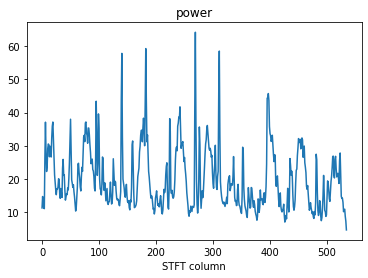

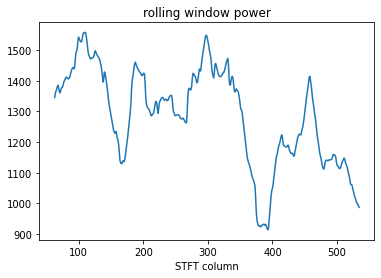

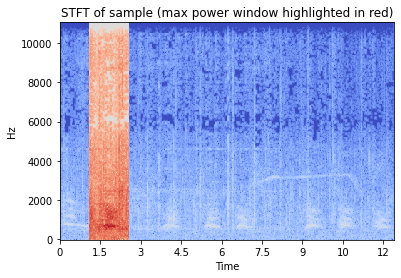

In [51]:
# Load the specified dog bark sample
row_ind = 100
row = metadata.iloc[row_ind]
y,sr = load_data(row,sr=22050)

# Parameters used in calculating the Short-Time Fourier Transform (STFT), and finding the max window
n_fft = 512  # When calculating the STFT, number of signal points to integrate over for each STFT column
hop_length = n_fft//4  # When calculating the STFT, number of signal points to skip between each STFT column
freq_min = 0  # minimum frequency considered when calculating power
freq_max = 20000  # maximum frequency considered when calculating power
rolling_length = 64  # How many STFT columns to consider for each window as we roll over the whole sample's STFT

# Calculate the STFT and split it into magnitude and phase
ySF, y_phase = librosa.magphase(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))

# Converting to decibell; effectively just a logarithmic transform of the STFT magnitude
S_db = librosa.amplitude_to_db(ySF, ref=np.max)

# If the windows we consider are longer than the whole sample's STFT, clamp it down
rolling_length = min(rolling_length,S_db.shape[1])

# The power (technically log-power) is the sum along each STFT column
power = np.sum(ySF[freq_min:freq_max,:],axis=0)
plt.plot(power)
plt.title('power')
plt.xlabel('STFT column')
plt.show()

# Calculate the power in the rolling window of chosen length
power_rolling = pd.Series(power).rolling(rolling_length, center=False).sum()
plt.plot(power_rolling)
plt.title('rolling window power')
plt.xlabel('STFT column')
plt.show()

# Find the position of the window containing the maximum (log-)power,
# and plot a spectrogram highlighting it
best_window_ind = np.argmax(power_rolling)
S_db_highlight = S_db.copy()
S_db_highlight[:,(best_window_ind-rolling_length+1):(best_window_ind+1)]+=80
librosa.display.specshow(S_db_highlight, x_axis='time', y_axis='linear', sr=sr)
plt.title('STFT of sample (max power window highlighted in red)')
plt.show()

The spectrogram above highlights in red the chosen "max power window", which turns out to be a single bark. You can listen to the full audio sample and compare to just the window's audio:

In [22]:
# Find the audio waveform just in the max power window
y_window = y[(max(best_window_ind-rolling_length+1,0)*hop_length):((best_window_ind+1)*hop_length)]

# Allow the audio to be heard
max_amp = max(abs(y))
print('Full audio:')
display(IPython.display.Audio(data=y/(max_amp*10), rate=sr, normalize=False))
print('Windowed audio:')
display(IPython.display.Audio(data=y_window/(max_amp*10), rate=sr, normalize=False))

Full audio:


Windowed audio:


We now extract a list of features from this chosen window:
1. Spectral flatness: A measure of how close to white noise the sound is in a STFT column. A flat spectrum indicates white noise, while defined tones lead to a non-flat spectrum.
2. Spectral centroid: Centroid of spectral power in an STFT column.
3. Spectral bandwidth: Range around the spectral centroid that contains the majority of the power in an STFT column.
4. Spectral rolloff frequency: Frequency below which 85% of the power is contained, in a STFT column.
5. Zero crossing rate: How often the waveform crosses the zero of the y-axis, as a fraction of window length.
6. Mean power crossing rate: How often the waveform's (log-)power crosses its mean in the window, as a fraction of window length
7. Power bands: Similar to Feature Set 1, the power contained within frequency bands is calculated and normalized, though confined to the chosen window.

For entries 1 to 4 listed above, the actual features are the descriptive statistics of each entry: mean, median, standard deviation, inter-quartile range, maximum, minimum.

For entries 5 and 6, they are each a scalar-valued feature.

For entry 7, we calculate the bands for a variety of chosen cutoff separations, both linear and logarithmic in frequency.

(Note that, for some of the listed features, we also calculate them in the whole sample as well as in the chosen window, for later comparison during feature pruning.)

First, define some helper functions:

In [23]:
# Given time series y, gives ratio of points where y crosses xval vs total points. xval=0 gives Zero cross rate
def cross_rate(y, xval):  
    return np.sum(np.diff(y>xval))/len(y-1)

In [24]:
# Does a bunch of common stats like mean, median, etc
def desc_stat(y, name: str):  
    
    y_nanless = y[~np.isnan(y)]
    if len(y_nanless) == 0:
        return None
    
    if len(name)>0:
        name+='_'
    
    desc_stat = {}
    desc_stat[name+'mean'] = np.mean(y_nanless)
    desc_stat[name+'median'] = np.median(y_nanless)
    desc_stat[name+'std'] = np.std(y_nanless)
    desc_stat[name+'iqr'] = np.quantile(y_nanless,.75) - np.quantile(y_nanless,.25)  # Inter-quartile range
    desc_stat[name+'max'] = np.max(y_nanless)
    desc_stat[name+'min'] = np.min(y_nanless)
    return desc_stat

In [27]:
# For f being magnitude as function of frequency,
# find the total power in n_bands equally divided bands, then scale between 0 and 1
def power_bands_scaled(f, n_bands, logfreq=False):
    if logfreq:
        bands = np.logspace(0, np.log10(len(f)), n_bands+1)
    else:
        bands = np.linspace(0, len(f), n_bands+1)
    
    digitized = np.digitize(range(len(f)), bands)
    f_banded = [np.sum(f[digitized == i]) for i in range(1, len(bands))]
    f_banded_scaled = (f_banded-np.min(f_banded))/(np.max(f_banded)-np.min(f_banded))
    
    #plt.bar(range(1, len(bands)), f_banded_scaled)
    #plt.show()
    
    f_banded_scaled = {i:f_banded_scaled[i] for i in range(n_bands)}
    return f_banded_scaled

Now define the function that prepares the features for one audio file:

In [28]:
def engineer_features(row, *, n_fft, hop_length, freq_min, freq_max, rolling_length):
    features = {}
    
    # Load the data and obtain its STFT
    y, sr = load_data(row,sr=22050)
    y_stft_mag, y_stft_phase = librosa.magphase(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    S_db = librosa.amplitude_to_db(y_stft_mag, ref=np.max) # Converting to decibell is effectively just a logarithmic transform
    
    # Cap the rolling window length if it's longer than the audio sample
    rolling_length = min(rolling_length,S_db.shape[1])
    
    # Note here we use 'power' (loosely) to refer to 'sum of log magnitudes'
    y_power = np.sum(S_db[freq_min:freq_max,:],axis=0)
    y_power_rolling = pd.Series(y_power).rolling(rolling_length, center=False).sum()
    
    # Finding the window with len=rolling_length that has maximum power
    best_window_ind = np.argmax(y_power_rolling) 
    y_window = y[(max(best_window_ind-rolling_length+1,0)*hop_length):((best_window_ind+1)*hop_length)]
    
    ### For the following features, 'mw' in the name means the feature was calculated in the maximum power window
    
    # Zero crossing rate
    features['y_mw_zcr'] = cross_rate(y_window,0)  # Zero crossing rate of the base signal in the max window
    
    # Mean power crossing rate
    S_db_window = S_db[:,max(best_window_ind-rolling_length+1,0):(best_window_ind+1)]
    y_power_window = np.sum(S_db_window, axis=0)
    features['y_mw_power_mcr'] = cross_rate(y_power_window,np.median(y_power_window))
    
    spec_flatness = librosa.feature.spectral_flatness(y=y, S=y_stft_mag, n_fft=n_fft, hop_length=hop_length)[0]
    spec_flatness_window = spec_flatness[max(best_window_ind-rolling_length+1,0):(best_window_ind+1)]
    
    spec_centroid = librosa.feature.spectral_centroid(y=y, S=y_stft_mag, n_fft=n_fft, hop_length=hop_length)[0]
    spec_centroid_window = spec_centroid[max(best_window_ind-rolling_length+1,0):(best_window_ind+1)]
    
    spec_bandwidth = librosa.feature.spectral_bandwidth(y=y, S=y_stft_mag, n_fft=n_fft, hop_length=hop_length)[0]
    spec_bandwidth_window = spec_bandwidth[max(best_window_ind-rolling_length+1,0):(best_window_ind+1)]
    
    spec_rolloff = librosa.feature.spectral_rolloff(y=y, S=y_stft_mag, n_fft=n_fft, hop_length=hop_length)[0]
    spec_rolloff_window = spec_rolloff[max(best_window_ind-rolling_length+1,0):(best_window_ind+1)]
        
    features['spec_flatness'] = desc_stat(spec_flatness,'')
    features['spec_flatness_mw'] = desc_stat(spec_flatness_window,'')
    
    features['spec_centroid'] = desc_stat(spec_centroid,'')
    features['spec_centroid_mw'] = desc_stat(spec_centroid_window,'')

    features['spec_bandwidth'] = desc_stat(spec_bandwidth,'')
    features['spec_bandwidth_mw'] = desc_stat(spec_bandwidth_window,'')
    
    features['spec_rolloff'] = desc_stat(spec_rolloff,'')
    features['spec_rolloff_mw'] = desc_stat(spec_rolloff_window,'')
    
    freq_power_window = np.sum(S_db_window, axis=1)/rolling_length
    
    # Power in various frequency band divisions
    features['bands_mw_5'] = power_bands_scaled(freq_power_window,5)
    features['bands_mw_10'] = power_bands_scaled(freq_power_window,10)
    features['bands_mw_20'] = power_bands_scaled(freq_power_window,20)
    features['logbands_mw_5'] = power_bands_scaled(freq_power_window,5,logfreq=True)
    features['logbands_mw_10'] = power_bands_scaled(freq_power_window,10,logfreq=True)
    features['logbands_mw_20'] = power_bands_scaled(freq_power_window,20,logfreq=True)
    
    return features

Finally, loop over all audio samples, for 3 different rolling window lengths, to obtain a nested dict of features.

WARNING: As mentioned previously, this feature generation is slow, we recommend using the provided final feature CSV.

In [33]:
%%time

# We use 3 sets of parameters for finding the max power window, though the only difference is the rolling length

stft_config_roll128 = {
    'n_fft' : 512, 
    'hop_length' : 512//4, 
    'freq_min' : 0,
    'freq_max' : 20000, 
    'rolling_length' : 128 
}

stft_config_roll64 = {
    'n_fft' : 512, 
    'hop_length' : 512//4, 
    'freq_min' : 0,
    'freq_max' : 20000, 
    'rolling_length' : 64 
}

stft_config_roll32 = {
    'n_fft' : 512, 
    'hop_length' : 512//4, 
    'freq_min' : 0,
    'freq_max' : 20000, 
    'rolling_length' : 32 
}


features = []

for i in range(len(metadata)):
    if i % 10 == 0:
        print(i)
    row = metadata.iloc[i]
    row_features_roll32 = engineer_features(row, **stft_config_roll32)
    row_features_roll64 = engineer_features(row, **stft_config_roll64)
    row_features_roll128 = engineer_features(row, **stft_config_roll128)
    features.append({
        'roll_32':row_features_roll32,
        'roll_64':row_features_roll64,
        'roll_128':row_features_roll128
    })


0
CPU times: total: 1.5 s
Wall time: 1.56 s


The nested dict containing the features can be saved in JSON format, but we instead flatten it into a pandas dataframe for CSV storage:

In [34]:
features_df = pd.json_normalize(features)
features_df.info()
features_df.head(10)
features_df.to_csv('large_data/features2.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Columns: 360 entries, roll_32.y_mw_zcr to roll_128.logbands_mw_20.19
dtypes: float32(240), float64(120)
memory usage: 18.9 KB


,roll_32.y_mw_zcr,roll_32.y_mw_power_mcr,roll_32.spec_flatness.mean,roll_32.spec_flatness.median,roll_32.spec_flatness.std,roll_32.spec_flatness.iqr,roll_32.spec_flatness.max,roll_32.spec_flatness.min,roll_32.spec_flatness_mw.mean,roll_32.spec_flatness_mw.median,...,roll_128.logbands_mw_20.10,roll_128.logbands_mw_20.11,roll_128.logbands_mw_20.12,roll_128.logbands_mw_20.13,roll_128.logbands_mw_20.14,roll_128.logbands_mw_20.15,roll_128.logbands_mw_20.16,roll_128.logbands_mw_20.17,roll_128.logbands_mw_20.18,roll_128.logbands_mw_20.19
0,0.072998,0.06250,0.002309,0.001231,0.003368,0.001361,0.029501,0.000103,0.001018,0.000988,...,0.968118,0.955391,0.920445,0.864527,0.796800,0.725948,0.650248,0.492378,0.267842,0.0
1,0.082764,0.12500,0.000615,0.000476,0.000969,0.000455,0.027115,0.000060,0.001112,0.001127,...,0.969706,0.964140,0.953262,0.922402,0.869128,0.792893,0.714129,0.545720,0.259913,0.0
2,0.080566,0.12500,0.000673,0.000509,0.002030,0.000459,0.070727,0.000061,0.000917,0.000830,...,0.971479,0.964323,0.933011,0.916912,0.858813,0.777171,0.667558,0.501494,0.257600,0.0
3,0.145020,0.18750,0.001481,0.000781,0.002131,0.001064,0.015160,0.000110,0.008745,0.008884,...,0.971445,0.965406,0.942749,0.920915,0.882215,0.824232,0.754719,0.666004,0.396134,0.0
4,0.067383,0.12500,0.000620,0.000516,0.000875,0.000479,0.029857,0.000072,0.000613,0.000569,...,0.967002,0.969604,0.938469,0.915971,0.864831,0.779472,0.679660,0.524466,0.255933,0.0
5,0.033203,0.28125,0.000546,0.000380,0.000964,0.000524,0.028214,0.000028,0.000507,0.000390,...,0.967554,0.958418,0.932315,0.903539,0.846835,0.774082,0.687581,0.535052,0.255622,0.0
6,0.062256,0.18750,0.000681,0.000511,0.000586,0.000614,0.004665,0.000048,0.001026,0.000954,...,0.961772,0.958521,0.937164,0.910006,0.868380,0.792578,0.703539,0.515313,0.261675,0.0
7,0.048096,0.21875,0.000693,0.000496,0.001012,0.000596,0.031650,0.000034,0.000507,0.000432,...,0.969947,0.958020,0.933414,0.906811,0.856068,0.787737,0.672531,0.513997,0.251731,0.0
8,0.029541,0.12500,0.000460,0.000311,0.001342,0.000366,0.046580,0.000029,0.000554,0.000480,...,0.965010,0.957664,0.934547,0.913309,0.872059,0.761078,0.645114,0.466841,0.251319,0.0
9,0.095947,0.12500,0.013912,0.000397,0.114892,0.000291,1.000001,0.000096,0.000613,0.000536,...,0.969403,0.972323,0.938127,0.898827,0.869710,0.834916,0.772687,0.652141,0.387553,0.0


## Feature Set 3: Fundamental frequency signal

This relatively small feature set revisits the idea of 'musicality' seen in Feature Set 1, but from a different perspective. Librosa provides an algorithm, pYIN, for fundamental frequency estimation. Given the Short-Time Fourier Transform (STFT) of an audio sample, the algorithm returns the estimated fundamental frequency in each column of the STFT, or NaN (not a number) if none is found. We realized that certain musically-leaning samples displayed clear fundamental frequency detection through this algorithm, while non-musical samples tended to mostly return NaNs.

The goal of this feature set is to first quantify how musical a sample is by calculating the ease of finding fundamental frequencies in the sample (equivalently, the ratio of NaNs to non-NaNs returned by the algorithm), and then listing descriptive statistics of the found fundamental frequencies, if any.

We demonstrate the method on an audio sample of street music:

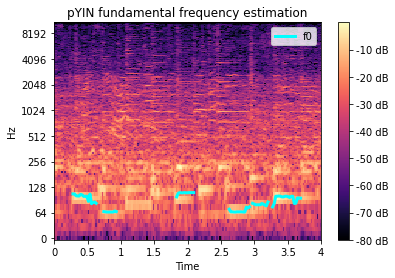

Fundamental frequency signal: 0.4682080924855492


In [40]:
# Load the chosen file
row_ind = 1
row = metadata[metadata['class']=='street_music'].iloc[row_ind]
y, sr = load_data(row,sr=22050)

# Apply the pYIN fundamental frequency estimation algorithm. Note that we specify the range of frequencies to check in.
f0, _, _ = librosa.pyin(y,fmin=librosa.note_to_hz('C2'),fmax=librosa.note_to_hz('C7'))

# Unit conversion for the time axis
times = librosa.times_like(f0)

# Plot the STFT (aka spectrogram) and show the detect fundamental frenquencies in cyan.
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
ax.set(title='pYIN fundamental frequency estimation')
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(times, f0, label='f0', color='cyan', linewidth=3)
ax.legend(loc='upper right')
plt.show()

# Print the fraction of non-NaNs to total sample length. Higher means more musical!
print(f'Fundamental frequency signal: {1-np.sum(np.isnan(f0))/len(f0)}')

#Audio can be listened to.
max_amp = max(abs(y))
display(IPython.display.Audio(data=y/(max_amp*10), rate=sr, normalize=False))

We loop over all audio samples, for 2 different frequency ranges, to obtain a nested dict of features, including both the above-described ratio of NaNs, as well as the descriptive statistics of the found fundamental frequencies.

WARNING: As mentioned previously, this feature generation is slow, we recommend using the provided final feature CSV.

In [42]:
# Helper function to generate the desired features
def f0_signal(y, fmin, fmax):  
    f0, _, _ = librosa.pyin(y,fmin=fmin,fmax=fmax)
    features = {}
    f0_stats = desc_stat(f0,'f0')
    if f0_stats is not None:
        features['f0_stats'] = f0_stats
    features['f0_signal'] = 1-np.sum(np.isnan(f0))/len(f0) # value from 0 to 1, indicating how much of the sample is discerned to have a fundamental frequency
    return features

In [45]:
%%time

# Loop over the data samples, generating the features for two different frequency ranges.

feature_f0 = []

for i in range(len(metadata)):
    if i % 10 == 0:
        print(i)
    row = metadata.iloc[i]
    y, sr = load_data(row,sr=22050)
    range_low = f0_signal(y,librosa.note_to_hz('C2'),librosa.note_to_hz('C7'))
    range_high = f0_signal(y,librosa.note_to_hz('C5'),librosa.note_to_hz('C9'))
    feature_f0.append({
        'range_low':range_low,
        'range_high':range_high
    })

0
CPU times: total: 15.3 s
Wall time: 15.3 s


The nested dict containing the features can be saved in JSON format, but we instead flatten it into a pandas dataframe for CSV storage. Note that, for data samples were no fundamental frequencies are returned, the descriptive statistics return NaNs. Some trial and error in the classification work described in a later notebook led us to conclude the best way to handle these was replacing them with zeros.

In [48]:
feature_f0_df = pd.json_normalize(feature_f0)
feature_f0_df = feature_f0_df.fillna(0) # Replace NaNs in descriptive statistics with zeros.
feature_f0_df.info()
feature_f0_df.head(10)
feature_f0_df.to_csv('large_data/features3.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   range_low.f0_signal            10 non-null     float64
 1   range_high.f0_stats.f0_mean    10 non-null     float64
 2   range_high.f0_stats.f0_median  10 non-null     float64
 3   range_high.f0_stats.f0_std     10 non-null     float64
 4   range_high.f0_stats.f0_iqr     10 non-null     float64
 5   range_high.f0_stats.f0_max     10 non-null     float64
 6   range_high.f0_stats.f0_min     10 non-null     float64
 7   range_high.f0_signal           10 non-null     float64
 8   range_low.f0_stats.f0_mean     10 non-null     float64
 9   range_low.f0_stats.f0_median   10 non-null     float64
 10  range_low.f0_stats.f0_std      10 non-null     float64
 11  range_low.f0_stats.f0_iqr      10 non-null     float64
 12  range_low.f0_stats.f0_max      10 non-null     float6

,range_low.f0_signal,range_high.f0_stats.f0_mean,range_high.f0_stats.f0_median,range_high.f0_stats.f0_std,range_high.f0_stats.f0_iqr,range_high.f0_stats.f0_max,range_high.f0_stats.f0_min,range_high.f0_signal,range_low.f0_stats.f0_mean,range_low.f0_stats.f0_median,range_low.f0_stats.f0_std,range_low.f0_stats.f0_iqr,range_low.f0_stats.f0_max,range_low.f0_stats.f0_min
0,0.000000,551.190730,552.768807,4.497652,7.156487,557.576667,544.841599,0.571429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,2279.768303,2282.437616,170.241756,328.066133,2517.936841,2080.949703,0.109827,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.080925,1761.847747,1941.594727,405.183075,850.982713,2230.306669,1077.167118,0.294798,1128.712229,1115.153334,36.960305,57.225801,1195.191751,1077.167118
3,0.000000,552.046160,523.251131,41.031176,53.988435,666.915289,523.251131,0.260116,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.040462,2128.539240,2129.589597,36.620152,49.205062,2191.991335,2057.047957,0.156069,66.850514,65.785287,1.875716,1.731598,70.915367,65.406391
5,0.549133,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,71.664066,68.499729,6.619412,11.996459,87.307058,65.406391
6,0.127168,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66.324975,65.406391,1.633327,0.952187,71.326176,65.406391
7,0.566474,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,73.038573,70.100835,7.721365,12.181207,98.566561,65.406391
8,0.843931,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.221166,66.549675,7.497901,6.748554,103.228180,65.406391
9,0.000000,703.347267,702.514299,21.894254,26.279199,744.275557,674.664472,0.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Next Steps

Once the three feature sets were generated, we combined them into a single CSV file, "extracted_features.csv". In the next notebook, we investigate the distributions of these features by class, before moving on to the classification notebook.

Code to combine CSVs:

In [ ]:
# Read the individual feature set files
features1 = pd.read_csv('large_data/features1.csv')
features2 = pd.read_csv('large_data/features2.csv')
features3 = pd.read_csv('large_data/features3.csv')

# Concatenate them into one dataframe and save to a final CSV file
pd.concat([features1, features2, features3], axis=1)